# Music Recommendation System

This workbook is developed as part of the final project for MIDS W207 - Applied Machine Learning at University of Berkeley. 

This project we explored the differnt machine learning algorithms (Decision Tree, Random Forest, and Gradient Boosting Machine) on the kkbox music dataset. (from [kkbox](https://www.kkbox.com/intl/index.php?area=intl)) 

A Recommender System is a process that seeks to predict user preferences.The recommender system aims to predict users' choices or interests, and based on these recommend the product items. There are multiple types of recommendation system as shown in the [chart]() below. It deals with large volume of information present by filtering the most important information based on the data provided by a user and other factors that take care of the user’s preference and interest. It finds out the right match between user and item and imputes the similarities between users and items for recommendation.

The organization of the jupyter notebook as presented below: 

#### Table of Contents:
* [What are Music Recommendation Systems?](#first-bullet)
* [Business Problem and Problem Statement for the project](#second-bullet)
* [Exploratory Data Analysis ](#third-bullet)
* [Data Processing & Feature Engineering](#fourth-bullet)
* [Building Models](#fifth-bullet)
* [Discussion on Results](#sixth-bullet)
* [Way-forward](#seventh-bullet)
* [References](#eigth-bullet)

## What are Music Recommendation Systems? <a class="anchor" id="first-bullet"></a>


Music Recommendation Systems are a type of Recommendation Systems which based on the the predicted user preferences recommend songs subject to multitude of factors. This systems in the past have become popular as the number of songs available exceeds the search and listening capacity of an individual and with jukebox and radio becoming obselete there is a good chance on missing out on songs that an individual would like to listen. 

Thus, Music service providers need an efficient way to manage songs and help their customers to discover music by giving a quality recommendation. For building this recommendation system, they deploy machine learning algorithms to process data from a million sources and present the listener with the most relevant songs.

There are mainly three types of recommendation system: **content-based**, **collaborative** and **popularity**. 

The **content-based** algorithms are given user preferences for items and recommend similar items based on a domain-specific notion of item content. This approach also extends naturally to cases where item metadata is available (e.g., movie stars, book authors, and music genres). 

The **collaborative-based** system perhaps the most well-known approach to recommendation, to the point that it’s sometimes seen as synonymous with the field. The main idea is that you’re given a matrix of preferences by users for items, and these are used to predict missing preferences and recommend items with high predictions.

The **popularity-based** system predicts based on the most popular songs amongst the users, however personalization in such a system is not possible. 

In this case study, we will be looking towards some good techniques to recommend music to brand new as well as existing users. By building this system, we aim to provide a better user experience for the app users.

## Business Problem and Problem Statement <a class="anchor" id="second-bullet"></a>


The 11th ACM International Conference on Web Search and Data Mining (WSDM 2018) challenged to build a better music recommendation system using a donated dataset from KKBOX. WSDM (pronounced “wisdom”) is one of the premier conferences on web inspired research involving search and data mining.

The glory days of Radio DJs have passed, and musical gatekeepers have been replaced with personalizing algorithms and unlimited streaming services. With easy access to various kinds of music across the globe, public is now listening to all kinds of music. Existing algorithms, however, struggle in key areas. Without enough historical data, how would an algorithm know if listeners will like a new song or a new artist? And how would it know what songs to recommend brand new users?

The dataset is from KKBOX, Asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. The input contains text data only, and no audio features. They currently use a collaborative filtering based algorithm with matrix factorization and word embedding in their recommendation system but believe new techniques could lead to better results.

## Problem Statement 

* Predict the changes of a user re-listening to a song. Basically understand what factors effect the users changes of listening to songs

* What are the top five songs that are members more likely to listen to?

## Exploratory Data Analysis <a class="anchor" id="third-bullet"></a>

The data was made available by [kakkle](https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data). 

Data files:
* members.csv: User profile data such as age, gender, city etc. 
* songs.csv: Information on the listed songs such as name, language, length, genre
* extra_song.csv: Extra information on the listed songs based on ISCR codes
* train.csv: member and source event information 

This is an important stage as we can dive deep into the data in this stage and derive useful insights which will then prove vital during Feature Engineering and Building Machine Learning Mode

In [2]:
%matplotlib inline
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 

from scipy.stats import norm
from scipy import stats
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")
color = sns.color_palette()

In [3]:
fp = "data/"
train = pd.read_csv(fp+"train.csv")
test=pd.read_csv(fp+"test.csv")
members=pd.read_csv(fp+"members.csv",parse_dates=['registration_init_time','expiration_date']) #reading the date format
songs=pd.read_csv(fp+"songs.csv")
extra_songs = pd.read_csv(fp+"song_extra_info.csv")

In [4]:
def summary(df):
    '''
    Function to summarize the records for the respective dataframe.
    '''

    print("Total number of records: ",len(df))
    for i in df.columns:
        print('Distinct {} in dataframe: {}'.format(i,len(np.unique(df[i].astype('str')))))


def count_na(df):
    
    new=pd.DataFrame(df.isnull().astype('int').sum(axis=0),columns=["NA_count"])
    new['Percentage']=df.isnull().astype('int').sum(axis=0)*100/len(df)
    return new


def data_category_counter(df):
    counters = dict()
    for col in df.columns:
        counters[col] = Counter(df[col])
    return counters

def genres_separate(genre_ids):
    
    genre_dictionary = {}
    for genre_id in genre_ids:
        if type(genre_id) != str:
            continue
        genre_list = genre_id.split('|')
        for genre in genre_list:
            if genre not in genre_dictionary:
                genre_dictionary[genre] = 1
            else:
                genre_dictionary[genre] += 1
    
    return genre_dictionary  

Train Data Exploration

In [ ]:
train.head(5)

In [ ]:
summary(train)

In [ ]:
np.mean(train.target)

In [ ]:
count_na(train) 

In [ ]:
a = train.groupby('source_system_tab').size()
a = pd.DataFrame(a)
a.reset_index(level=0, inplace=True)
a.columns = ['Source System Tab', 'Count']
a = a.sort_values(by='Count', ascending=False)
print(a)
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Source System Tab', y='Count', kind='bar',
                 data=a, height=6, palette='ch:2.5,-.2,dark=.4', aspect=1.5)
ax.fig.suptitle('Distribution of Source System Tab', fontsize=15)
ax.fig.subplots_adjust(top=.9)
plt.show()


We can see that my library contributes to maximum of song events, followed by discover and search. This also looks intutive as we mostly use our libraries to listen to songs. Let us explore the same relation in respect of the repeat percentage to see which level of source system tab contributes maximum to repeat events.

In [ ]:
repeat_df = train.groupby(['source_system_tab']).mean(
).sort_values(by='target', ascending=False)
print(repeat_df)

repeat_df.reset_index(level=0, inplace=True)
repeat_df.columns = ['Source System Tab', 'Target']
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Source System Tab', y='Target', kind='bar', palette="ch:7,-.2,dark=.4",
                 data=repeat_df, height=6, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Source System Tab v/s Target', fontsize=15)
plt.show()


As suspected, my library has maxmium repeat percentage followed by settings, explore, serach and discover. Note that settings and explore have less events yet have high conversions.

In [ ]:
Name = train.groupby(['source_screen_name']).mean(
).sort_values(by='target', ascending=False)
Name.reset_index(level=0, inplace=True)
Name.columns = ['Source Screen Name', 'Target']
# print(Name)
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Source Screen Name', y='Target', kind='bar', palette="ch:12,-.2,dark=.4",
                 data=Name, height=6, aspect=1.5)
ax.fig.suptitle('Source Screen Name v/s Target', fontsize=15)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)

Similar to previous observation, Local playlist more has high events and repeat percentage

In [ ]:
Type = train.groupby(['source_type']).mean().sort_values(by='target', ascending=False)
Type.reset_index(level=0, inplace=True)
Type.columns = ['Source Type', 'Target']
# print(Name)
plt.rcParams["axes.labelsize"] = 15
# Plot a simple histogram with binsize determined automatically
ax = sns.catplot(x='Source Type', y='Target', kind='bar', palette="ch:.12,0,dark=.4",
                 data=Type, height=6, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Source Type v/s Target', fontsize=15)

for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)

In [ ]:
Type = train.groupby(['song_id']).sum().sort_values(by='target', ascending=False)
Type.reset_index(level=0, inplace=True)
Type.columns = ['Source Type', 'Views']

new = Type.groupby(['Views']).count()
new.reset_index(inplace=True)
new.columns = ['Views', 'Log_Count']
new['Log_Count'] = np.log(new.Log_Count)
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Views', y='Log_Count', kind='strip', color='red', height=7, aspect=1.5,
                 data=new)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of Views', fontsize=15)
ax.set(xticks=[])
plt.show()

Understanding the relationship between variables and target variable. 

In [ ]:
repeat_df = train.groupby(['source_system_tab']).mean(
).sort_values(by='target', ascending=False)
print(repeat_df)

repeat_df.reset_index(level=0, inplace=True)
repeat_df.columns = ['Source System Tab', 'Target']
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Source System Tab', y='Target', kind='bar', palette="ch:7,-.2,dark=.4",
                 data=repeat_df, height=6, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Source System Tab v/s Target', fontsize=15)
plt.show()

Member data exploration

In [ ]:
members.registration_init_time = pd.to_datetime(
    members.registration_init_time.astype('str'))
members.expiration_date = pd.to_datetime(members.expiration_date.astype('str'))

summary(members)

In [ ]:
count_na(members)

In [ ]:
city = members.groupby(['city']).size()
city = pd.DataFrame(city)
city.reset_index(level=0, inplace=True)
city.columns = ['City_ID', 'Count']

plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='City_ID', y='Count', kind='bar', palette="ch:2,0.3,dark=.4",
                 data=city, height=6, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of City IDs', fontsize=15)
plt.show()

In [ ]:
members['gender'] = members.gender.replace(np.NaN, 'NA')
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='gender', kind='count', palette="ch:23,0.3,dark=.4",
                 data=members, height=6, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of Gender', fontsize=15)
plt.show()

In [ ]:
df = members['registration_init_time'].value_counts()
df.columns = ['Registration Date', 'Count']
plt.subplots(figsize=(10, 7))
plt.rcParams["axes.labelsize"] = 15
ax = sns.lineplot(data=df, color='yellow', size=20)
ax.set(xlabel='Registration Date', ylabel='Count')
ax.set_title("Distribution of Registration Date", fontsize=15)
plt.show()

Song Data Exploration

In [ ]:
songs.head(5)

In [ ]:
summary(songs)

In [ ]:
count_na(songs)

In [ ]:
language_name = {
    31:'Chinese',
    52:'English',
    -1:'White-Noise',
    3:'Chinese2',
    17:'Japanese',
    24:'Cantonese',
    10:'Taiwanese',
    45:'Thai',
    59:'Chinese',
    38:'English'
}

In [ ]:
language = songs.groupby(['language']).size()
language = pd.DataFrame(language)
language.reset_index(level=0, inplace=True)
language.columns = ['Language', 'Count']
language = language.sort_values(by='Count', ascending=False)
language['Language'] = language['Language'].astype('str')

ax = sns.catplot(x='Language', y='Count', kind='bar', order=language['Language'],
                 palette="ch:10,-0.1,dark=.4", data=language, height=5, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of Language of the songs', fontsize=15)
plt.show()

#ax.savefig('song_language.png')

In [ ]:
print((songs.song_length/6e4).describe())
print("\n")
print("Number of songs which have length greater than 10 minutes:{}".format(songs.query('song_length/6e4>10').shape[0]))
plt.subplots(figsize=(10, 7))
#x = ((songs.query('song_length/6e4<10')).song_length/6e4)
x = songs.song_length/6e4
ax = sns.distplot(x, color='black')
ax.set_title('Distribution of Song Length', fontsize=15)
ax.set(xlabel='Song Length', ylabel='Count')
plt.show()
# ax.savefig('song_length_wo_outliers.png')

In [ ]:
print((songs.song_length/6e4).describe())
print("\n")
print("Number of songs which have length greater than 10 minutes:{}".format(songs.query('song_length/6e4>10').shape[0]))
plt.subplots(figsize=(10, 7))
x = ((songs.query('song_length/6e4<10')).song_length/6e4)
#x = songs.song_length/6e4
ax = sns.distplot(x, color='black')
ax.set_title('Distribution of Song Length', fontsize=15)
ax.set(xlabel='Song Length', ylabel='Count')
plt.show()
# ax.savefig('song_length_wo_outliers.png')

In [ ]:
gener_count = genres_separate(songs.genre_ids)
gener_df = pd.DataFrame.from_dict(
    gener_count, orient='index', columns=['counts'])
gener_df.reset_index(level=0, inplace=True)
gener_df = gener_df.sort_values(by='counts', ascending=False)
gener_df.columns = ['Genre', 'Count']
gener_df = gener_df[0:50]
ax = sns.catplot(x='Genre', y='Count', kind='bar', order=gener_df['Genre'],
                 palette="ch:7,-0.8,dark=.4", data=gener_df, height=7, aspect=2)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of first 50 Genre of the songs', fontsize=15)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
gener_count = genres_separate(songs.genre_ids)
gener_df = pd.DataFrame.from_dict(
    gener_count, orient='index', columns=['counts'])
gener_df.reset_index(level=0, inplace=True)
gener_df = gener_df.sort_values(by='counts', ascending=False)
gener_df.columns = ['Genre', 'Count']
gener_df = gener_df[0:10]
ax = sns.catplot(x='Genre', y='Count', kind='bar', order=gener_df['Genre'],
                 palette="ch:7,-0.8,dark=.4", data=gener_df, height=7, aspect=2)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of Top Genre of the songs', fontsize=15)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
listen_log = train[['msno',
                    'song_id',
                    'target']].merge(songs[['song_id',
                                            'artist_name',
                                            'genre_ids',
                                            'language']],
                                             on='song_id')

In [ ]:
print('10 Most repeated artists:')
listen_log[listen_log.target==1].groupby('artist_name').size().nlargest(10).reset_index(name='count')

In [ ]:
print('10 Most skipped artists:')
listen_log[listen_log.target==0].groupby('artist_name').size().nlargest(10).reset_index(name='count')

Data Cleaning + feature Engineering 

In [7]:
song_cols = ['song_id', 'artist_name', 'genre_ids', 'song_length', 'language']
# Merge all data files
train = train.merge(songs[song_cols], how='left', on='song_id')
train = train.merge(members, how='left', on='msno')
train = train.merge(extra_songs, how='left', on='song_id')

In [8]:
# Correction in column type
members.city = members.city.astype('category')
members.registered_via = members.registered_via.astype('category')
songs.language = songs.language.astype('category')

In [9]:
def add_datepart(x, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    df = x.copy()
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
    return df

# Using isrc to extract years
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

# Counted features
def genre_id_count(x):
    if pd.isnull(x):
        return -1
    else:
        return x.count('|')+1

def artist_count(x):
    if pd.isnull(x):
        return -1
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

# def is_featured(x):
#     if 'feat' in str(x) :
#         return 1
#     return 0

def song_play_times(song_ids): 
    song_play_dict = {}

    for song_id in song_ids:
        if song_id not in song_play_dict:
            song_play_dict[song_id] = 1
        else:
            song_play_dict[song_id] += 1
    
    return song_play_dict

In [10]:
# Fetaure addition 
def add_days_left(train):
    train['membership_days'] = (train.expiration_date - train.registration_init_time).dt.days.astype('int')
    train['membership_days'] = train['membership_days']//200
    train['membership_days'] = train['membership_days'].astype('category')
    return train

def add_genre_count(train):
    train['genre_count'] = train['genre_ids'].apply(genre_id_count).astype(np.int8)
    return train


def add_artist_count(train):
    train['artist_count'] = train['artist_name'].apply(artist_count).astype(np.int8)
    return train

# def add_featured_song(train):
#     train['features'] = train['artist_name'].apply(is_featured).astype(np.int8)
#     return train


def add_song_year(train):
    train['song_year'] = train['isrc'].apply(isrc_to_year)
    train.drop(['isrc', 'name'], axis = 1, inplace = True)
    return train


def add_song_play_count(train):
    song_count = song_play_times(train['song_id'])
    song_count_df = pd.DataFrame.from_dict(song_count,orient='index',columns=['song_play_counts'])
    song_count_df.reset_index(level=0, inplace=True)
    song_count_df = song_count_df.rename(columns={'index':'song_id'})
    train = train.merge(song_count_df,how='left',on='song_id')
    return train

def add_artist_played_count(train):
    artist_count = pd.DataFrame.from_dict(song_play_times(train['artist_name']),
                                      orient='index',columns=['artist_song_count']).reset_index()
    artist_count = artist_count.rename(columns={'index':'artist_name'})
    train = train.merge(artist_count,how='left',on='artist_name')
    return train  

def add_msno_appear_count(train):
    msno_count = pd.DataFrame.from_dict(song_play_times(train['msno']),
                                      orient='index',columns=['msno_appear_count']).reset_index()
    msno_count = msno_count.rename(columns={'index':'msno'})
    train = train.merge(msno_count,how='left',on='msno')
    return train  
    
    
def add_datepart_reg(train):
    train = add_datepart(train, 'registration_init_time')
    return train

def add_datepart_exp(train):
    train = add_datepart(train,'expiration_date')
    return train

def count_and_percent(df, colnames:list):
    for i in colnames:
        counter = pd.DataFrame.from_dict(Counter(df[i]),
                       orient='index', columns=[i+'_count']).reset_index()
        counter.columns = [i,i+'_count']
        df = df.merge(counter, how='left',on=i)
        agg = df.groupby(by=['msno',i]).agg({'song_id':['count']})
        agg.columns = agg.columns.get_level_values(0)
        agg.columns = [i+'_user_lev_c']
        df = df.merge(agg,how='left',on=['msno',i])
    return df

def split_genre_columns(train):
    df = train.copy()
    df['genre_ids'] = df['genre_ids'].astype(str)
    df = pd.concat([df,df['genre_ids'].str.split('|',expand=True)],axis=1)
    df = df.drop(columns='genre_ids',axis= 1)
    return df

In [11]:
# Apply features form pipeline
def apply_features(train, feature_list):
    for i in feature_list:
        train = i(train)
    return train

In [12]:
def fillna_nan(df, cat_list, contlist):
    train = df.copy()
    for col in cat_list:
        train[col] = train[col].fillna('nan')
    for col in contlist:
        train[col] = train[col].fillna(-1)
    return train

In [13]:
train['song_length']=train['song_length']/6e4
#train['genre_ids'] = train['genre_ids'].str.split('|').str[0]

In [14]:
features_pipeline = [add_days_left, 
                     add_datepart_reg, 
                     add_datepart_exp, 
                     add_genre_count, 
                     add_artist_count, 
                     add_song_year,
                     add_msno_appear_count,
                     add_song_play_count, 
                     add_artist_played_count]

x = apply_features(train, features_pipeline)
collist = ['source_system_tab', 'source_screen_name', 'source_type', 'artist_name']
x = count_and_percent(x,collist)
x = split_genre_columns(x)

In [21]:
x.source_type.unique()

array(['online-playlist', 'local-playlist', 'local-library',
       'top-hits-for-artist', 'album', nan, 'song-based-playlist',
       'radio', 'song', 'listen-with', 'artist', 'topic-article-playlist',
       'my-daily-playlist'], dtype=object)

In [16]:
count_na(x)

,NA_count,Percentage
msno,0,0.000000
song_id,0,0.000000
source_system_tab,24849,0.336825
source_screen_name,414804,5.622618
source_type,21539,0.291959
target,0,0.000000
artist_name,114,0.001545
song_length,114,0.001545
language,150,0.002033
city,0,0.000000


In [15]:
x.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,song_length,language,city,...,artist_name_count,artist_name_user_lev_c,0,1,2,3,4,5,6,7
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,Bastille,3.441183,52.0,1,...,1140,3.0,359,None,None,None,None,None,None,None
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,Various Artists,4.743067,52.0,13,...,303616,24.0,1259,None,None,None,None,None,None,None
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,Nas,3.756600,52.0,13,...,289,2.0,1259,None,None,None,None,None,None,None
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,Soundway,4.258533,-1.0,13,...,1,1.0,1019,None,None,None,None,None,None,None
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,Brett Young,3.130033,52.0,1,...,427,1.0,1011,None,None,None,None,None,None,None


In [ ]:
#testing isrc_to_year
assert 'expiration_Year' in x
assert len(x['expiration_Year']) != 0

In [134]:
df =x.copy()

In [135]:
# Data imputation block

cat_nan_list = ['msno', 'song_id', 'source_screen_name', 
    'source_system_tab', 'source_type', 
    'artist_name', 'gender']
cont_nan_list = ['song_length','language', 'song_year']

df = fillna_nan(df, cat_nan_list, cont_nan_list)

In [136]:
df['language']=df['language'].astype('int64')
df['song_year']=df['song_year'].astype('int64')
df['membership_days']=df['membership_days'].astype('int64')

df = df.iloc[:,:-8]

In [137]:
col_list = ['msno','song_id','source_system_tab','source_screen_name','source_type','artist_name','gender']

# Label encoding for the categorical varaibles 
from sklearn import preprocessing
def encoder(ls,data):
    le = preprocessing.LabelEncoder()
    for column_name in ls:
            if data[column_name].dtype.name in ['category','object']:
                data[column_name] = le.fit_transform(data[column_name].astype(str))

# Encode the data
encoder(col_list,df)

In [138]:
df = df.drop(columns=['source_system_tab_user_lev_c',
                      'source_screen_name_user_lev_c',
                      'source_type_user_lev_c',
                      'artist_name_user_lev_c'],axis=1)
df = df.fillna(-1)

In [139]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,song_length,language,city,...,genre_count,artist_count,song_year,msno_appear_count,song_play_counts,artist_song_count,source_system_tab_count,source_screen_name_count,source_type_count,artist_name_count
0,8158,74679,1,7,7,1,3277,3.441183,52,1,...,1,1,2016,5511,215,1140,167949,72342,1967924,1140
1,17259,223479,3,8,4,1,31960,4.743067,52,13,...,1,1,1999,622,1,303616,3684730,3228202,1079503,303616
2,17259,120758,3,8,4,1,21372,3.756600,52,13,...,1,1,2006,622,4,289,3684730,3228202,1079503,289
3,17259,23707,3,8,4,1,27439,4.258533,-1,13,...,1,1,2010,622,1,1,3684730,3228202,1079503,1
4,8158,33308,1,7,7,1,4472,3.130033,52,1,...,1,1,2016,5511,412,427,167949,72342,1967924,427


In [140]:
from sklearn.model_selection import train_test_split
import random

# Features and target varaibles
X = df.drop(columns='target',axis=1)
y = df['target']

# Train and test split
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2)

# Train and validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.2)

# Sampled data
idx = random.sample(range(0,X_train.shape[0]), 100000)
X_train_sampled = X_train.iloc[idx]
y_train_sampled = y_train.iloc[idx]

In [141]:
from sklearn.metrics import accuracy_score
m = LogisticRegression()
m.fit(X_train_sampled, y_train_sampled )
predicted = m.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score validation: {accuracy:.3}')

Mean accuracy score validation: 0.614


In [142]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#Fitting a model on sampled data
sk_reg = lgb.sklearn.LGBMClassifier(
         objective='binary',
         eval_metric='binary_logloss',
         boosting='gbdt',
         learning_rate=0.3 ,
         verbose=0,
         num_leaves=600,
         bagging_freq= 1,
         feature_fraction= 0.9,
         max_bin= 256,
         max_depth= 300,
         num_rounds= 200,
)


sk_reg.fit(X_train_sampled, y_train_sampled)

LGBMClassifier(bagging_freq=1, boosting='gbdt', boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0,
               eval_metric='binary_logloss', feature_fraction=0.9,
               importance_type='split', learning_rate=0.3, max_bin=256,
               max_depth=300, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=600,
               num_rounds=200, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [143]:
predicted = sk_reg.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score: {accuracy:.3}')

Mean accuracy score: 0.645


                               cols   imp
1                           song_id  9134
6                       song_length  8937
31                 song_play_counts  8374
0                              msno  8152
30                msno_appear_count  7951
5                       artist_name  7522
32                artist_song_count  7226
19    registration_init_timeElapsed  5700
16        registration_init_timeDay  5434
18  registration_init_timeDayofyear  4515


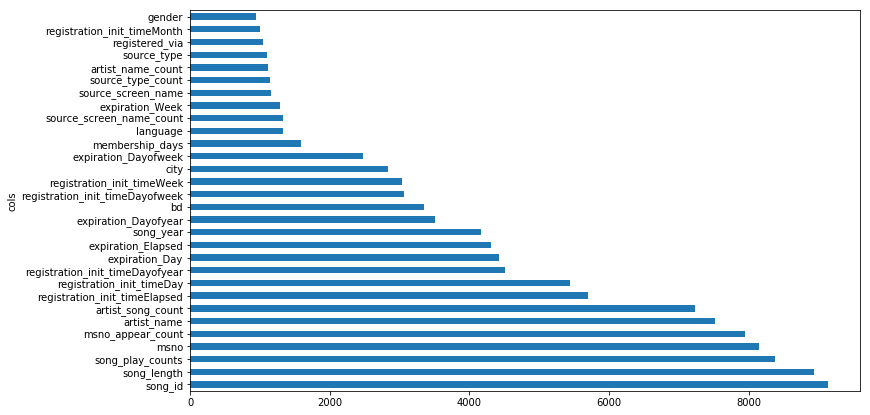

In [144]:
### Feature selection

def lgb_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = lgb_feat_importance(sk_reg, X_train_sampled ); 
print(fi[:10])

def plot_fi(fi):return fi.plot('cols', 'imp', 'barh',
                               figsize=(12,7), legend=False)
plot_fi(fi[:30])
plt.show()

In [145]:
# Pipeline and grid search
pipe_dt = Pipeline([('clf', lgb.sklearn.LGBMClassifier())]) # Estimator: ML algorithm

grid_params = dict(
         clf__objective=['binary'],
         clf__eval_metric=['binary_logloss'],
         clf__boosting_type=['gbdt'],
         clf__learning_rate=[0.3] ,
         clf__verbose=[0],
         clf__num_leaves=[300, 350, 250],
         clf__feature_fraction= [0.9],
         clf__max_bin= [256],
         clf__max_depth= [200, 150, 250],
         clf__num_rounds= [200])
gs = GridSearchCV(estimator=pipe_dt,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_train_sampled, y_train_sampled)
f"{gs.score(X_test, y_test):.4f}"

'0.6405'

In [146]:
# Best algorithm with best hyperparameters 
# (need to fit it to find specific model parameters)
print(gs.best_estimator_)

# Best model with specific model parameters
gs.best_estimator_.get_params()['clf']

Pipeline(memory=None,
         steps=[('clf',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0,
                                eval_metric='binary_logloss',
                                feature_fraction=0.9, importance_type='split',
                                learning_rate=0.3, max_bin=256, max_depth=200,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=300, num_rounds=200,
                                objective='binary', random_state=None,
                                reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_bin=200000,
                                subsample_freq=0, verbose=0))],
         verbose=False)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eval_metric='binary_logloss', feature_fraction=0.9,
               importance_type='split', learning_rate=0.3, max_bin=256,
               max_depth=200, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=300,
               num_rounds=200, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [147]:
#Fitting the best model on all the data
Final_model = lgb.sklearn.LGBMClassifier(objective='binary',
                                         eval_metric='binary_logloss',
                                         boosting='gbdt',
                                         learning_rate=0.3 ,
                                         verbose=0,
                                         num_leaves=600,
                                         bagging_freq= 1,
                                         feature_fraction= 0.9,
                                         max_bin= 256,
                                         max_depth= 300,
                                         num_rounds= 200)

In [148]:
#Validation accuracy
Final_model.fit(X_train, y_train)
predicted = Final_model.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score on validation: {accuracy:.3}')

Mean accuracy score on validation: 0.734


In [149]:
# Predict probability for ROC curve
predicted = Final_model.predict_proba(X_test)

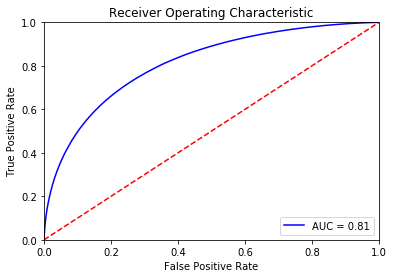

In [150]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

false_positive_rate, true_positive_rate, thresholds = roc_curve(
    y_test, [i[1]for i in predicted])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate,
         'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()